### <img src="https://img.icons8.com/bubbles/50/000000/information.png" style="height:50px;display:inline"> Students Information
---

|Name     |Campus Email| ID  |
|---------|--------------------------------|----------|
|Maayan Ella| maayanella@campus.technion.ac.il| 314715228|
|Gilad Zilberman| zilberman@campus.technion.ac.il| 206012064|

### <img src="https://img.icons8.com/bubbles/50/000000/upload-to-cloud.png" style="height:50px;display:inline"> Project Description
---
In the following code we implemented a NBA predictor that tries to predict the next game result based of the home's team previoes games, away's teams previous games and previous matchup between them.


### <img src="https://img.icons8.com/officel/80/000000/code.png" style="height:50px;display:inline"> **Setup The Environment**
---

In [1]:
!pip install torchmetrics

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [1]:
import os
import xgboost as xgb
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, random_split
import torchmetrics
import matplotlib.pyplot as plt
import random
import time
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
import seaborn as sns
import math

%matplotlib inline
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

In [3]:
if torch.cuda.is_available():
  device = "cuda"
else:
  device = "cpu"

### <img src="https://img.icons8.com/color/48/000000/code.png" style="height:50px;display:inline"> Data Load And Preprocessing
---

In [2]:
# loading the data
col_names = ['season_id', 'team_id_home', 'game_id', 'game_date','fgm_home', 'fga_home', 'fg_pct_home', 'fg3m_home', 'fg3a_home', 'fg3_pct_home', 'ftm_home', 'fta_home', 'ft_pct_home', 'oreb_home', 'dreb_home', 'reb_home', 'ast_home', 'stl_home', 'blk_home', 'tov_home', 'pf_home', 'pts_home', \
                          'team_id_away',                        'fgm_away', 'fga_away', 'fg_pct_away', 'fg3m_away', 'fg3a_away', 'fg3_pct_away', 'ftm_away', 'fta_away', 'ft_pct_away', 'oreb_away', 'dreb_away', 'reb_away', 'ast_away', 'stl_away', 'blk_away', 'tov_away', 'pf_away', 'pts_away',  \
            'season_type' ]

data = pd.read_csv("./games_datasets.csv", usecols=col_names)

# Convert data to boolean
data['game_id'] = data['game_id'].astype(int)
data['season_id'] = data['season_id'].astype(int)
data['team_id_home'] = (data['team_id_home'].astype(int))%100
data['team_id_away'] = (data['team_id_away'].astype(int))%100
data['game_date'] = pd.to_datetime(data['game_date']).dt.year

# Create new columns for faster training and better results
columns = ['fga', 'fg_pct', 'fg3a', 'fg3_pct', 'fta', 'ft_pct', 'oreb', 'dreb', 'ast', 'stl', 'blk', 'tov', 'pf', 'pts']
for col in columns:
    data[f'diff_{col}'] = data[f'{col}_home'] - data[f'{col}_away']

# add boolean Label to each Row
data['label'] = (data['pts_home'] > data['pts_away']).astype(int)
data['row_num'] = np.arange(1, len(data)+1)
data.head()

,season_id,team_id_home,game_id,game_date,fgm_home,fga_home,fg_pct_home,fg3m_home,fg3a_home,fg3_pct_home,...,diff_oreb,diff_dreb,diff_ast,diff_stl,diff_blk,diff_tov,diff_pf,diff_pts,label,row_num
0,41979,47,47900044,1980,48.0,95.0,0.505,0.0,1.0,0.00,...,10.0,8.0,-2.0,-2.0,-4.0,6.0,6.0,-3.0,0,1
1,41979,55,47900045,1980,45.0,93.0,0.484,1.0,4.0,0.25,...,-9.0,-10.0,14.0,7.0,3.0,-7.0,0.0,-10.0,0,2
2,41979,55,47900048,1980,47.0,89.0,0.528,0.0,6.0,0.00,...,-10.0,-6.0,0.0,-10.0,7.0,1.0,5.0,-16.0,0,3
3,41980,38,48000048,1981,41.0,95.0,0.432,0.0,1.0,0.00,...,6.0,6.0,0.0,-9.0,2.0,9.0,1.0,3.0,1,4
4,41980,38,48000049,1981,41.0,82.0,0.500,0.0,3.0,0.00,...,1.0,12.0,1.0,0.0,-1.0,13.0,10.0,-2.0,0,5


In [4]:
# StandardScaler
columns_to_scale = [
  'season_id', 'fgm_home', 'fga_home', 'fg_pct_home', 'fg3m_home', 'fg3a_home', 'fg3_pct_home', 'ftm_home', 'fta_home', \
  'ft_pct_home', 'oreb_home', 'dreb_home', 'reb_home', 'ast_home', 'stl_home', 'blk_home', 'tov_home', \
  'pf_home', 'pts_home', 'fgm_away', 'fga_away', 'fg_pct_away', 'fg3m_away', 'fg3a_away', 'fg3_pct_away', \
  'ftm_away', 'fta_away', 'ft_pct_away', 'oreb_away', 'dreb_away', 'reb_away', 'ast_away', 'stl_away', \
  'blk_away', 'tov_away', 'pf_away', 'pts_away', 'diff_fga', 'diff_fg_pct', 'diff_fg3a', 'diff_fg3_pct', \
  'diff_fta', 'diff_ft_pct', 'diff_oreb', 'diff_dreb', 'diff_ast', 'diff_stl', 'diff_blk', 'diff_tov', 'diff_pf', 'diff_pts' \
]

scaler = preprocessing.StandardScaler().fit(data[columns_to_scale])
data[columns_to_scale] = scaler.transform(data[columns_to_scale])


In [5]:
# StandardScaler for Teams ID:
IDcoloumns_to_scale = ['team_id_home' , 'team_id_away']
unique_id_home = data['team_id_home'].unique()
unique_id_away = data['team_id_away'].unique()
std_id_home = unique_id_home.std()
avg_id_home = unique_id_home.mean()
std_id_away = unique_id_away.std()
avg_id_away = unique_id_away.mean()
data['team_id_home'] = round((data['team_id_home'] - avg_id_home) / std_id_home, 3)
data['team_id_away'] = round((data['team_id_away'] - avg_id_away) / std_id_away, 3)

data_rs = data[data['season_type'] != "Playoffs"]
print("Number of valid Matches/Rows: \n\tAll Games ", len(data), "\n\tRegular Seasons Games ", len(data_rs))

Number of valid Matches/Rows: 
	All Games  44549 
	Regular Seasons Games  41866


In [6]:
# defines dict of Games pre Team:
team_dfs_rs = {}
for team_id in range(37, 67):
    normalized_id = round((team_id - avg_id_home) / std_id_home, 3)
    team_dfs_rs[str(normalized_id)] = data_rs[
        (data_rs['team_id_home'] == normalized_id) | (data_rs['team_id_away'] == normalized_id)
    ].reset_index()


team_dfs_full = {}
for team_id in range(37, 67):
    normalized_id = round((team_id - avg_id_home) / std_id_home, 3)
    team_dfs_full[str(normalized_id)] = data[
        (data['team_id_home'] == normalized_id) | (data['team_id_away'] == normalized_id)
    ].reset_index()

In [8]:
# Function that create Batch number of preivious games per input row:
def get_train_batch(team_dfs,row, team_hist_size, matchup_hist_size, id_home , id_away):

  X_home = team_dfs[str(id_home)].iloc[:team_dfs[str(id_home)][team_dfs[str(id_home)]['row_num'] == row].index[0]]
  X_away = team_dfs[str(id_away)].iloc[:team_dfs[str(id_away)][team_dfs[str(id_away)]['row_num'] == row].index[0]]

  prev_labels_home =    X_home[((X_home['team_id_home'] == id_home) | (X_home['team_id_away'] == id_home)) & ((X_home['team_id_home'] != id_away) & (X_home['team_id_away'] != id_away))].drop(['index', 'game_id', 'game_date','season_type', 'row_num'], axis=1).tail(team_hist_size)
  prev_labels_away =    X_away[((X_away['team_id_home'] == id_away) | (X_away['team_id_away'] == id_away)) & ((X_away['team_id_home'] != id_home) & (X_away['team_id_away'] != id_home))].drop(['index', 'game_id', 'game_date','season_type', 'row_num'], axis=1).tail(team_hist_size)
  prev_labels_matchup = X_home[((X_home['team_id_home'] == id_home) | (X_home['team_id_away'] == id_home)) & ((X_home['team_id_home'] == id_away) | (X_home['team_id_away'] == id_away))].drop(['index', 'game_id', 'game_date','season_type', 'row_num'], axis=1).tail(matchup_hist_size+1).head(matchup_hist_size)

  prev_labels_combained = pd.concat([prev_labels_home, prev_labels_away, prev_labels_matchup])[:(2*team_hist_size + matchup_hist_size)]
  return prev_labels_combained

### <img src="https://img.icons8.com/color/48/000000/code.png" style="height:50px;display:inline"> Working On Regular Season Only
---

In [9]:
# Create initial X_db and Y_db data sets accurding to size history.
counter = 0
X_db = []
Y_db = []
start_time = time.time()
# {{100, 5} {80, 4} {60, 4} {40, 3} {20, 3} {10, 2}}
team_hist_size = 100 ;
matchup_hist_size = 5 ;

# using onlu regular seasons games:
for i in range(1,len(data_rs)):
  row_num, id_home, id_away  = data_rs.iloc[i][['row_num', 'team_id_home', 'team_id_away']]
  train_batch = get_train_batch(team_dfs_rs,int(row_num), team_hist_size, matchup_hist_size, id_home , id_away)
  if len(train_batch) == (2*team_hist_size + matchup_hist_size):
    counter += 1
    if counter % 1000 == 0:
      end_time = time.time()
      elapsed_time = end_time - start_time
      print(f"Iteration: {counter} Elapsed time: {elapsed_time:.2f} seconds")
      start_time = time.time()
    Y_db.append(data_rs.iloc[i]['label'])
    X_db.append(train_batch)


print("Number of valid game's batches: ", counter)


Iteration: 1000 Elapsed time: 14.20 seconds
Iteration: 2000 Elapsed time: 7.05 seconds
Iteration: 3000 Elapsed time: 7.27 seconds
Iteration: 4000 Elapsed time: 6.31 seconds
Iteration: 5000 Elapsed time: 5.86 seconds
Iteration: 6000 Elapsed time: 5.81 seconds
Iteration: 7000 Elapsed time: 6.06 seconds
Iteration: 8000 Elapsed time: 6.26 seconds
Iteration: 9000 Elapsed time: 7.01 seconds
Iteration: 10000 Elapsed time: 6.66 seconds
Iteration: 11000 Elapsed time: 6.59 seconds
Iteration: 12000 Elapsed time: 5.98 seconds
Iteration: 13000 Elapsed time: 6.06 seconds
Iteration: 14000 Elapsed time: 6.00 seconds
Iteration: 15000 Elapsed time: 6.38 seconds
Iteration: 16000 Elapsed time: 6.28 seconds
Iteration: 17000 Elapsed time: 6.53 seconds
Iteration: 18000 Elapsed time: 6.30 seconds
Iteration: 19000 Elapsed time: 6.56 seconds
Iteration: 20000 Elapsed time: 6.10 seconds
Iteration: 21000 Elapsed time: 6.14 seconds
Iteration: 22000 Elapsed time: 6.21 seconds
Iteration: 23000 Elapsed time: 6.20 seco

In [25]:
# Drop unrelavent columns:
columns = data.drop(['game_id', 'game_date','season_type', 'row_num'], axis=1).columns
X_db_tmp = np.array(X_db)

new_columns = []
for i in range(1, (2*team_hist_size + matchup_hist_size)+1):
    for col in columns:
        new_columns.append(f"{col}_{i:02d}")

X_db_rs = pd.DataFrame(X_db_tmp.reshape(X_db_tmp.shape[0], -1), columns = new_columns)
Y_db_rs = pd.DataFrame(Y_db)
print("X_db_rs Shape: ", X_db_rs.shape)
print("Y_db_rs Shape: ", Y_db_rs.shape)

X_db_rs Shape:  (39344, 11070)
Y_db_rs Shape:  (39344, 1)


In [11]:

X_tv, X_test, Y_tv, Y_test = train_test_split(X_db_rs, Y_db_rs, test_size=0.1, stratify=Y_db_rs)
X_train, X_val, Y_train, Y_val = train_test_split(X_tv, Y_tv, test_size=0.11, stratify=Y_tv)

print("Train Shape: ", X_train.shape)
print("Validation Shape: ",X_val.shape)
print("Test Shape: ",X_test.shape)


Train Shape:  (31514, 11070)
Validation Shape:  (3895, 11070)
Test Shape:  (3935, 11070)


### <img src="https://img.icons8.com/color/48/000000/code.png" style="height:50px;display:inline"> Baseline Models
---

In [30]:
# Use Logistic Regression on 15% of the sampels:

shrink_X_test = X_test[:int(len(X_test)*0.15)]
shrink_Y_test = Y_test[:int(len(Y_test)*0.15)]

Y_train_reval = Y_train.values.ravel()
logistic_model = LogisticRegression(max_iter=3000, solver='lbfgs')
logistic_model.fit(X_train[:int(len(X_train)*0.15)], Y_train_reval[:int(len(Y_train_reval)*0.15)])

Y_pred = logistic_model.predict(shrink_X_test)

shrink_Y_test_np = shrink_Y_test.to_numpy().reshape(-1)
num_mislabeled = (shrink_Y_test_np != Y_pred).sum()
total_points = shrink_X_test.shape[0]
print("Number of mislabeled points %d out of %d total points." % (num_mislabeled, total_points))
print("Accuracy:", accuracy_score(shrink_Y_test_np, Y_pred))

Number of mislabeled points 283 out of 590 total points.
Accuracy: 0.5203389830508475


In [31]:
# Use Logistic Regression on all of the sampels:

Y_train_reval = Y_train.values.ravel()
logistic_model = LogisticRegression(max_iter=3000, solver='lbfgs')
logistic_model.fit(X_train, Y_train_reval)

Y_pred = logistic_model.predict(X_test)

Y_test_np = Y_test.to_numpy().reshape(-1)
num_mislabeled = (Y_test_np != Y_pred).sum()
total_points = X_test.shape[0]
print("Number of mislabeled points %d out of %d total points." % (num_mislabeled, total_points))
print("Accuracy:", accuracy_score(Y_test_np, Y_pred))

Number of mislabeled points 1740 out of 3935 total points.
Accuracy: 0.5578144853875476


In [32]:
# Several hyper-parameters tunning iterations:

## ROUND 1
# param_grid = {
#   'max_depth': [4, 10],
#   'learning_rate': [0.01, 0.05],
#   'gamma': [0, 0.5],
#   'reg_lambda': [0, 1.0],
#   'scale_pos_weight': [1, 3],
#   'n_estimators': [1, 10]
# }
# ---- {'gamma': 0, 'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 10, 'reg_lambda': 1.0, 'scale_pos_weight': 3}
## ROUND 2
# param_grid = {
#   'max_depth': [8,10],
#   'learning_rate': [0.05, 0.1],
#   'gamma': [0, 0.25],
#   'reg_lambda': [1.0, 5.0],
#   'scale_pos_weight': [3,5],
#   'n_estimators': [10,100]
# }
# ---- {'gamma': 0, 'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 100, 'reg_lambda': 5.0, 'scale_pos_weight': 3}
## ROUND 3
# param_grid = {
#   'max_depth': [7, 8 ,9],
#   'learning_rate': [0.04, 0.05, 0.07],
#   'gamma': [0, 0.05],
#   'reg_lambda': [5.0, 10.0],
#   'scale_pos_weight': [2,3,4],
#   'n_estimators': [100,200]
# }
# ---- {'gamma': 0.05, 'learning_rate': 0.07, 'max_depth': 8, 'n_estimators': 100, 'reg_lambda': 5.0, 'scale_pos_weight': 3}
## ROUND 4
# param_grid = {
#   'max_depth': [8],
#   'learning_rate': [0.07, 0.08],
#   'gamma': [0.04, 0.05, 0.06],
#   'reg_lambda': [4.0, 5.0, 6.0],
#   'scale_pos_weight': [3],
#   'n_estimators': [100,150]
# }
# # ---- {'gamma': 0.04, 'learning_rate': 0.08, 'max_depth': 8, 'n_estimators': 100, 'reg_lambda': 6.0, 'scale_pos_weight': 3}

# optimal_params = GridSearchCV(
#   estimator=xgb.XGBClassifier(objective='binary:logistic',
#                               seed=42,
#                               subsample=0.9,
#                               colsample_bytree=0.5,
#                               early_stopping_rounds=10,
#                               eval_metric='error'),
#   param_grid=param_grid,
#   scoring='roc_auc',
#   verbose=True,
#   n_jobs=10,
#   cv=3
# )


# optimal_params.fit(X_train, Y_train,
#                    eval_set=[(X_test, Y_test)],
#                    verbose=False)
# print(optimal_params.best_params_)


In [33]:
# Prediction by using XGBoots Classifier:
NBA_xgb = xgb.XGBClassifier(
    gamma=0.04,
    learning_rate=0.08,
    reg_lambda=6.0,
    scale_pos_weight=3,
    subsample=0.9,
    colsample_bytree=0.5,
    max_depth=8,
    n_estimators=100,
    objective='binary:logistic'
)

NBA_xgb.fit(X_train, Y_train)

y_pred = NBA_xgb.predict(X_test)

accuracy = accuracy_score(Y_test, np.round(y_pred))
print("Accuracy:", accuracy)


Accuracy: 0.6007623888182974


### <img src="https://img.icons8.com/color/48/000000/code.png" style="height:50px;display:inline"> CNN Model
---

In [12]:
# define device:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [13]:
# CNN model
class NBA_CNN(nn.Module):
  def __init__(self,size):
    super(NBA_CNN, self).__init__()
    self.conv_layer = nn.Sequential(
      nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1),
      nn.BatchNorm2d(16),
      nn.ReLU(inplace=True),
      nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
      nn.BatchNorm2d(32),
      nn.MaxPool2d(kernel_size=2, stride=2),
      nn.Dropout2d(p=0.3),
      nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(inplace=True),
      nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
      nn.BatchNorm2d(128),
      nn.ReLU(inplace=True),
      nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
      nn.BatchNorm2d(128),
      nn.Dropout2d(p=0.3),
      nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(inplace=True),
      nn.Conv2d(in_channels=64, out_channels=48, kernel_size=3, padding=1),
      nn.BatchNorm2d(48),
      nn.ReLU(inplace=True),
      nn.Conv2d(in_channels=48, out_channels=32, kernel_size=3, padding=1),
      nn.BatchNorm2d(32),
      nn.ReLU(inplace=True),
      nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, padding=1),
      nn.BatchNorm2d(16),
      nn.Dropout2d(p=0.3),
      nn.ReLU(inplace=True),
      nn.Conv2d(in_channels=16, out_channels=8, kernel_size=3, padding=1),
      nn.ReLU(inplace=True),
      nn.MaxPool2d(kernel_size=2, stride=2),
    )

    if  size==100: first_fc = 5304
    elif size==80: first_fc = 4264
    elif size==60: first_fc = 3224
    elif size==40: first_fc = 2080
    elif size==20: first_fc = 1040
    elif size==10: first_fc = 520
    self.fc_first_layer = nn.Sequential(
        nn.Dropout(p=0.3),
        nn.Linear(first_fc, 512),
        nn.ReLU(inplace=True)
    )

    self.fc_second_layer = nn.Sequential(
      nn.Linear(512, 256),
      nn.ReLU(inplace=True),
      nn.Linear(256, 48),
      nn.ReLU(inplace=True),
      nn.Dropout(p=0.3),
      nn.Linear(48, 1)
    )

  def forward(self, x):
    x = x.unsqueeze(1)
    x = self.conv_layer(x)
    x = x.view(x.size(0), -1)
    x = self.fc_first_layer(x)
    x = self.fc_second_layer(x)
    return x


team_hist_size = 100
model = NBA_CNN(team_hist_size).to(device)

# Print model size and number of parameters:
num_params = sum([param.numel() for param in model.parameters() if param.requires_grad])
print(f'Number of parameters: {num_params:,}')

param_size = 0
for param in model.parameters():
  param_size += param.nelement() * param.element_size()
buffer_size = 0
for buffer in model.parameters():
  buffer_size += buffer.nelement() * buffer.element_size()
size_all_mb = (param_size + buffer_size) / (1024 ** 2)
print(f'Model size: {size_all_mb:.2f} MB')



Number of parameters: 3,226,793
Model size: 24.62 MB


In [14]:
# define training function:
def train_step(model: nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: nn.Module,
               optimizer: torch.optim.Optimizer):
  model.train()
  train_loss = 0
  train_acc = 0

  for X_train, Y_train in dataloader:
    X_train, Y_train = X_train.to(device), Y_train.to(device)
    Y_pred = model(X_train).reshape(-1)
    loss = loss_fn(Y_pred, Y_train)
    train_loss += float(loss)
    accuracy = torchmetrics.Accuracy(task='binary').to(device)
    train_acc += accuracy(Y_pred, Y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  train_loss /= len(dataloader)
  train_acc /= len(dataloader)
  return train_loss, train_acc

# define validation function:
def val_step(model: nn.Module,
            dataloader: torch.utils.data.DataLoader,
            loss_fn: nn.Module):
  val_loss = 0
  val_acc = 0
  model.eval()
  with torch.no_grad():
    for X_val, Y_val in dataloader:
      X_val, Y_val = X_val.to(device), Y_val.to(device)
      Y_pred = model(X_val).squeeze(dim=1)
      loss = loss_fn(Y_pred, Y_val)
      val_loss += float(loss)
      accuracy = torchmetrics.Accuracy(task='binary').to(device)
      val_acc += accuracy(Y_pred, Y_val)

    val_loss /= len(dataloader)
    val_acc /= len(dataloader)
  return val_loss, val_acc


def Implement_train_val(model: torch.nn.Module,
                        train_dataloader: torch.utils.data.DataLoader,
                        val_dataloader: torch.utils.data.DataLoader,
                        loss_fn: torch.nn.Module,
                        optimizer: torch.optim.Optimizer,
                        epochs: int,
                        check: str,
                        to_print: bool=True):
  results = {'train_loss': [],
               check+'_loss': [],
               'train_acc': [],
               check+'_acc': []}
  max_val_acc = 0
  best_model = None


  for epoch in range(epochs):
    start_time = time.time()
    train_loss, train_acc = train_step(model=model, dataloader=train_dataloader, loss_fn=criterion, optimizer=optimizer)
    val_loss, val_acc = val_step(model=model, dataloader=val_dataloader, loss_fn=criterion)

    initial_lr = optimizer.param_groups[0]['lr']
    scheduler.step(val_acc)
    end_time = time.time()
    elapsed_time = end_time - start_time
    if (to_print) and (epoch % 1 == 0) :
      current_lr = scheduler.get_last_lr()[0]
      print(f"\033[1m\033[4mEpoch: {epoch}\033[0m")
      print(f'Train loss: {train_loss:.4f} |\t Val loss: {val_loss:.4f}')
      print(f'Train acuracy: {train_acc:.4f} |\t Val accuracy: {val_acc:.4f}')
      print(f'LR: {current_lr:.8f} \t epoch time: {elapsed_time:.2f} seconds')
      print('-' * 45 ,"\n")


    if max_val_acc < val_acc:
      max_val_acc = val_acc
      best_model = model

    # update results dictionary to a list
    results['train_loss'].append(train_loss)
    results[check+'_loss'].append(val_loss)
    results['train_acc'].append(train_acc)
    results[check+'_acc'].append(val_acc)

    if epoch == epochs - 1:
      print(f'Best VAL accuracy: {max_val_acc}')

  return results, best_model


In [43]:
# re-shape the data and convert to TensorDatasets for usign GPU:

Xcnn_tv, Xcnn_test, Ycnn_tv, Ycnn_test = train_test_split(X_db, Y_db, test_size=0.1, stratify=Y_db)
Xcnn_train, Xcnn_val, Ycnn_train, Ycnn_val = train_test_split(Xcnn_tv, Ycnn_tv, test_size=0.11, stratify=Ycnn_tv)

Xcnn_train_exp = np.array(Xcnn_train)
Xcnn_val_exp = np.array(Xcnn_val)
Xcnn_test_exp = np.array(Xcnn_test)

Ycnn_train = np.array(Ycnn_train)
Ycnn_val = np.array(Ycnn_val)
Ycnn_test = np.array(Ycnn_test)

tensor_train_ds = TensorDataset(torch.tensor(Xcnn_train_exp, dtype=torch.float), torch.tensor(Ycnn_train, dtype=torch.float))
tensor_val_ds =   TensorDataset(torch.tensor(Xcnn_val_exp,   dtype=torch.float), torch.tensor(Ycnn_val,   dtype=torch.float))
tensor_test_ds =  TensorDataset(torch.tensor(Xcnn_test_exp,  dtype=torch.float), torch.tensor(Ycnn_test,  dtype=torch.float))


In [39]:

torch.cuda.empty_cache()

batch_size = 128
learning_rate = 0.0001
num_epochs = 30
patience = 1
num_workers = 2
criterion = nn.BCEWithLogitsLoss()

# define model
model = NBA_CNN(team_hist_size).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=patience)


train_dataloader = DataLoader(dataset=tensor_train_ds, batch_size=batch_size, num_workers=num_workers,shuffle=True)
val_dataloader   = DataLoader(dataset=tensor_val_ds,   batch_size=int(batch_size/8), num_workers=num_workers,shuffle=False)

results, best_model = Implement_train_val(model, train_dataloader, val_dataloader, criterion, optimizer, num_epochs, "val")



KeyboardInterrupt: 

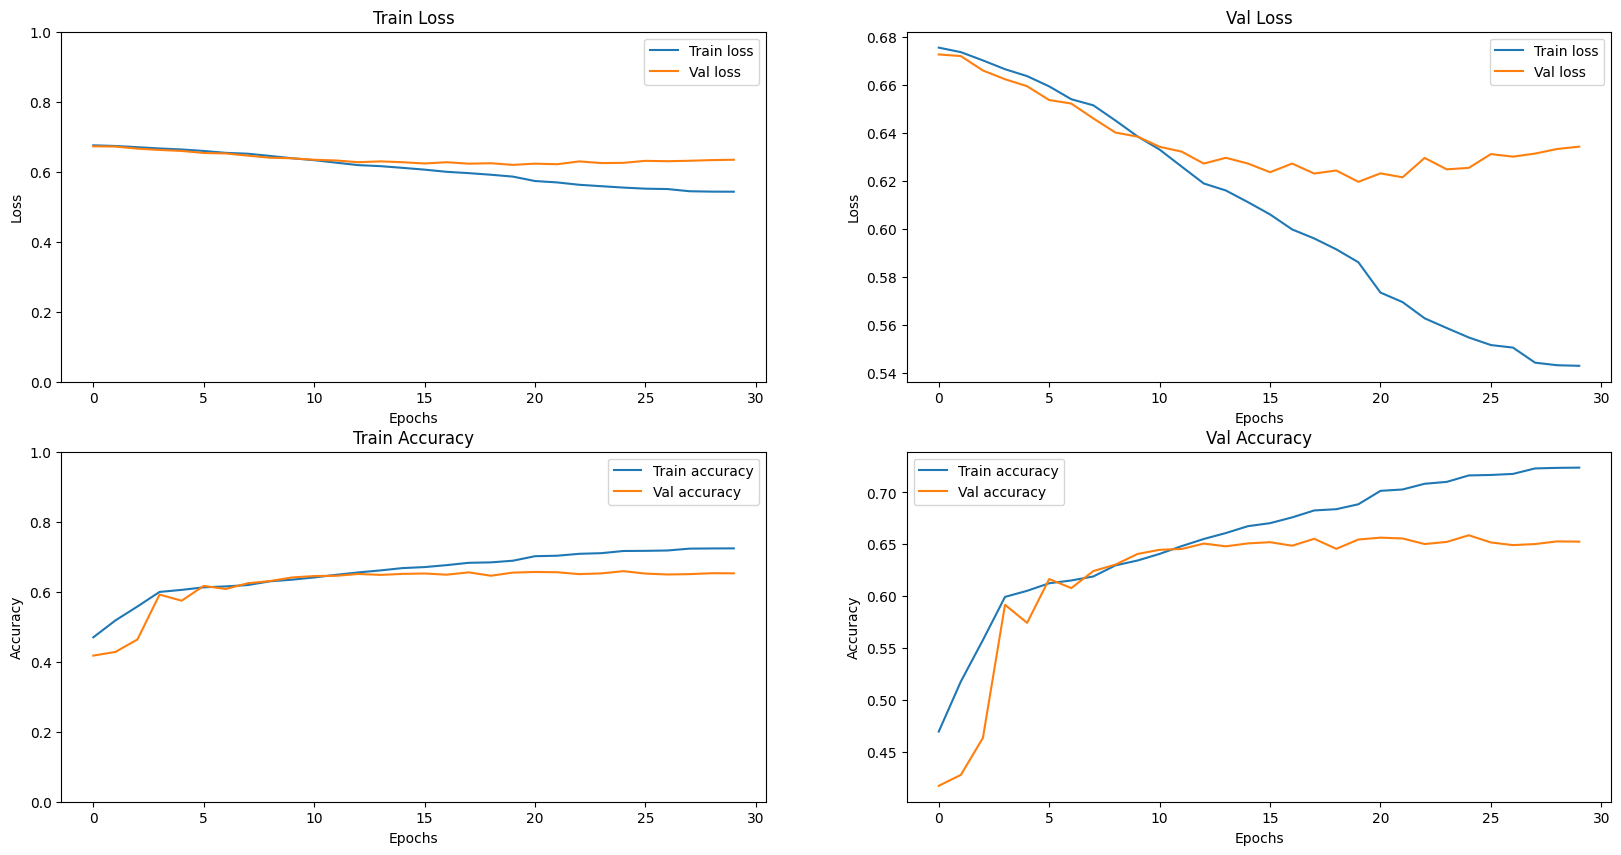

In [17]:
def plot_loss_curves(results: dict[str, list[float]],
                     check: str):
  epochs = range(len(results['train_loss']))

  # Create a 2x2 grid of subplots
  fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))

  axes[0, 0].plot(epochs, results['train_loss'], label='Train loss')
  axes[0, 0].plot(epochs, results[check+'_loss'], label=f'Val loss')
  axes[0, 0].set_title('Train Loss')
  axes[0, 0].set_xlabel('Epochs')
  axes[0, 0].set_ylabel('Loss')
  axes[0, 0].set_ylim(0, 1)
  axes[0, 0].legend()

  axes[0, 1].plot(epochs, results['train_loss'], label='Train loss')
  axes[0, 1].plot(epochs, results[check+'_loss'], label=f'Val loss')
  axes[0, 1].set_title(f'Val Loss')
  axes[0, 1].set_xlabel('Epochs')
  axes[0, 1].set_ylabel('Loss')
  axes[0, 1].legend()

  train_acc_np = [tensor.cpu().numpy() for tensor in results['train_acc']]
  val_acc_np = [tensor.cpu().numpy() for tensor in results[check+'_acc']]
  axes[1, 0].plot(epochs, train_acc_np, label='Train accuracy')
  axes[1, 0].plot(epochs, val_acc_np, label=f'Val accuracy')
  axes[1, 0].set_title('Train Accuracy')
  axes[1, 0].set_xlabel('Epochs')
  axes[1, 0].set_ylabel('Accuracy')
  axes[1, 0].set_ylim(0, 1)
  axes[1, 0].legend()

  axes[1, 1].plot(epochs, train_acc_np, label='Train accuracy')
  axes[1, 1].plot(epochs, val_acc_np, label=f'Val accuracy')
  axes[1, 1].set_title(f'Val Accuracy')
  axes[1, 1].set_xlabel('Epochs')
  axes[1, 1].set_ylabel('Accuracy')
  axes[1, 1].legend()

  plt.show()

plot_loss_curves(results, "val")

In [51]:
test_dataloader = DataLoader(dataset=tensor_test_ds,   batch_size=int(batch_size/8), num_workers=num_workers,shuffle=False)

test_loss, test_acc = val_step(model=best_model, dataloader=test_dataloader, loss_fn=criterion)

print(f'Test loss: {test_loss:.4f}')
print(f'Test accuracy: {test_acc:.4f}')

Test loss: 0.5196
Test accuracy: 0.7512


In [36]:
for data_point in tensor_test_ds:
    x, y = data_point
    print(x.shape)  # Print the shape of the input tensor
    print(y.shape)  # Print the shape of the target tensor
    break
for batch in test_dataloader:
    batch_x, batch_y = batch
    print(batch_x.shape)  # Print the shape of the input tensor
    print(batch_y.shape)  # Print the shape of the target tensor
    break



print(len(Xcnn_test))
print(Xcnn_test_exp.shape)
print(Ycnn_test.shape)


torch.Size([11070])
torch.Size([1])
torch.Size([16, 205, 54])
torch.Size([16])
3935
(3935, 11070)
(3935, 1)


### <img src="https://img.icons8.com/officel/80/000000/code.png" style="height:50px;display:inline"> **CNN Model Prediction on Playoffs Games**
---

In [19]:

counter = 0
X_db_pl = []
Y_db_pl = []
start_time = time.time()
# {{100, 5} {80, 4} {60, 4} {40, 3} {20, 3} {10, 2}}
team_hist_size = 100 ;
matchup_hist_size = 5 ;

for i in range(1,len(data)):
  if data.loc[i, 'season_type'] == 'Playoffs':
    row_num, id_home, id_away  = data.iloc[i][['row_num', 'team_id_home', 'team_id_away']]
    train_batch = get_train_batch(team_dfs_full,int(row_num), team_hist_size, matchup_hist_size, id_home , id_away)
    if len(train_batch) == (2*team_hist_size + matchup_hist_size):
      counter += 1
      if counter % 1000 == 0:
        end_time = time.time()
        elapsed_time = end_time - start_time
        print(f"Iteration: {counter} Elapsed time: {elapsed_time:.2f} seconds")
        start_time = time.time()
      X_db_pl.append(train_batch)
      Y_db_pl.append(data.iloc[i]['label'])

print(len(data), counter, (len(data)-counter))


Iteration: 1000 Elapsed time: 7.22 seconds
Iteration: 2000 Elapsed time: 7.51 seconds
44549 2519 42030


In [50]:

Xcnn_pl_exp = np.array(X_db_pl)
Ycnn_pl = np.array(Y_db_pl)

tensor_test_pl = TensorDataset(torch.tensor(Xcnn_pl_exp, dtype=torch.float), torch.tensor(Ycnn_pl, dtype=torch.float))
pl_dataloader = DataLoader(dataset=tensor_test_pl,   batch_size=int(batch_size/8), num_workers=num_workers,shuffle=False)

# predict on plyoffs games results on the BEST model
test_loss, test_acc = val_step(model=best_model, dataloader=pl_dataloader, loss_fn=criterion)

print(f'Test loss: {test_loss:.4f}')
print(f'Test accuracy: {test_acc:.4f}')

Test loss: 0.6660
Test accuracy: 0.6084


### <img src="https://img.icons8.com/officel/80/000000/code.png" style="height:50px;display:inline"> **CNN Model Prediction on Full Data**
---

In [53]:
counter = 0
X_db_full = []
Y_db_full = []
start_time = time.time()
# {{100, 5} {80, 4} {60, 4} {40, 3} {20, 3} {10, 2}}
team_hist_size = 100 ;
matchup_hist_size = 5 ;

# using ALL games:
for i in range(1,len(data)):
  row_num, id_home, id_away  = data.iloc[i][['row_num', 'team_id_home', 'team_id_away']]
  train_batch = get_train_batch(team_dfs_full,int(row_num), team_hist_size, matchup_hist_size, id_home , id_away)
  if len(train_batch) == (2*team_hist_size + matchup_hist_size):
    counter += 1
    if counter % 1000 == 0:
      end_time = time.time()
      elapsed_time = end_time - start_time
      print(f"Iteration: {counter} Elapsed time: {elapsed_time:.2f} seconds")
      start_time = time.time()
    X_db_full.append(train_batch)
    Y_db_full.append(data.iloc[i]['label'])

print("Number of valid game's batches: ", counter)


Iteration: 1000 Elapsed time: 14.55 seconds
Iteration: 2000 Elapsed time: 6.79 seconds
Iteration: 3000 Elapsed time: 7.39 seconds
Iteration: 4000 Elapsed time: 6.29 seconds
Iteration: 5000 Elapsed time: 5.88 seconds
Iteration: 6000 Elapsed time: 5.82 seconds
Iteration: 7000 Elapsed time: 5.93 seconds
Iteration: 8000 Elapsed time: 5.86 seconds
Iteration: 9000 Elapsed time: 7.18 seconds
Iteration: 10000 Elapsed time: 6.78 seconds
Iteration: 11000 Elapsed time: 6.22 seconds
Iteration: 12000 Elapsed time: 6.06 seconds
Iteration: 13000 Elapsed time: 5.99 seconds
Iteration: 14000 Elapsed time: 6.22 seconds
Iteration: 15000 Elapsed time: 6.26 seconds
Iteration: 16000 Elapsed time: 6.67 seconds
Iteration: 17000 Elapsed time: 6.62 seconds
Iteration: 18000 Elapsed time: 6.55 seconds
Iteration: 19000 Elapsed time: 6.91 seconds
Iteration: 20000 Elapsed time: 7.48 seconds
Iteration: 21000 Elapsed time: 6.26 seconds
Iteration: 22000 Elapsed time: 6.27 seconds
Iteration: 23000 Elapsed time: 6.24 seco

In [54]:
Xcnn_tv, Xcnn_test, Ycnn_tv, Ycnn_test = train_test_split(X_db_full, Y_db_full, test_size=0.1, stratify=Y_db_full)
Xcnn_train, Xcnn_val, Ycnn_train, Ycnn_val = train_test_split(Xcnn_tv, Ycnn_tv, test_size=0.11, stratify=Ycnn_tv)

Xcnn_train_exp = np.array(Xcnn_train)
Xcnn_val_exp = np.array(Xcnn_val)
Xcnn_test_exp = np.array(Xcnn_test)

Ycnn_train = np.array(Ycnn_train)
Ycnn_val = np.array(Ycnn_val)
Ycnn_test = np.array(Ycnn_test)

tensor_train_ds_full = TensorDataset(torch.tensor(Xcnn_train_exp, dtype=torch.float), torch.tensor(Ycnn_train, dtype=torch.float))
tensor_val_ds_full =   TensorDataset(torch.tensor(Xcnn_val_exp,   dtype=torch.float), torch.tensor(Ycnn_val,   dtype=torch.float))
tensor_test_ds_full =  TensorDataset(torch.tensor(Xcnn_test_exp,  dtype=torch.float), torch.tensor(Ycnn_test,  dtype=torch.float))

In [55]:

torch.cuda.empty_cache()

batch_size = 128
learning_rate = 0.0001
num_epochs = 30
patience = 1
num_workers = 2
criterion = nn.BCEWithLogitsLoss()

model = NBA_CNN(team_hist_size).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=patience)


train_dataloader = DataLoader(dataset=tensor_train_ds_full, batch_size=batch_size, num_workers=num_workers,shuffle=True)
val_dataloader   = DataLoader(dataset=tensor_val_ds_full,   batch_size=int(batch_size/8), num_workers=num_workers,shuffle=False)

results, best_model = Implement_train_val(model, train_dataloader, val_dataloader, criterion, optimizer, num_epochs, "val")


Epoch: 0
Train loss: 0.6749 |	 Val loss: 0.6721
Train acuracy: 0.4598 |	 Val accuracy: 0.3971
LR: 0.00010000 	 epoch time: 90.31 seconds
--------------------------------------------- 

Epoch: 1
Train loss: 0.6695 |	 Val loss: 0.6480
Train acuracy: 0.5268 |	 Val accuracy: 0.6205
LR: 0.00010000 	 epoch time: 90.21 seconds
--------------------------------------------- 

Epoch: 2
Train loss: 0.6531 |	 Val loss: 0.6440
Train acuracy: 0.6167 |	 Val accuracy: 0.6275
LR: 0.00010000 	 epoch time: 90.17 seconds
--------------------------------------------- 

Epoch: 3
Train loss: 0.6502 |	 Val loss: 0.6407
Train acuracy: 0.6195 |	 Val accuracy: 0.6268
LR: 0.00010000 	 epoch time: 90.15 seconds
--------------------------------------------- 

Epoch: 4
Train loss: 0.6461 |	 Val loss: 0.6426
Train acuracy: 0.6245 |	 Val accuracy: 0.6304
LR: 0.00010000 	 epoch time: 90.14 seconds
--------------------------------------------- 

Epoch: 5
Train loss: 0.6449 |	 Val loss: 0.6365
Train acuracy: 0.6276 |	 Va

In [56]:

full_dataloader = DataLoader(dataset=tensor_test_ds_full,   batch_size=int(batch_size/8), num_workers=num_workers,shuffle=False)

test_loss, test_acc = val_step(model=best_model, dataloader=full_dataloader, loss_fn=criterion)

print(f'Test loss: {test_loss:.4f}')
print(f'Test accuracy: {test_acc:.4f}')

Test loss: 0.6337
Test accuracy: 0.6374


### <img src="https://img.icons8.com/officel/80/000000/code.png" style="height:50px;display:inline"> Print Graphs and Illustration
---

### <img src="https://img.icons8.com/color/48/000000/code.png" style="height:50px;display:inline"> History Size Comparison Graphs
---

In [ ]:
# Print 3 layer-depth XGBoots classifier tree:
NBA_xgb = xgb.XGBClassifier(
    gamma=0.04,
    learning_rate=0.08,
    reg_lambda=6.0,
    scale_pos_weight=3,
    subsample=0.9,
    colsample_bytree=0.5,
    max_depth=3,
    n_estimators=100,
    objective='binary:logistic'
)

bst = NBA_xgb.get_booster()
for importance_type in ('weight', 'gain', 'cover', 'total_gain', 'total_cover'):
  print('%s:' % importance_type, bst.get_score (importance_type=importance_type))

node_params = {'shape': 'box',
               'style': 'filled, rounded',
               'fillcolor': '#78cbe'}
leaf_params = {'shape': 'box',
               'style': 'filled',
               'fillcolor': '#e48038'}

xgb.to_graphviz(NBA_xgb, num_trees=0,size="10,10",
                condition_node_params=node_params, leaf_node_params=leaf_params)

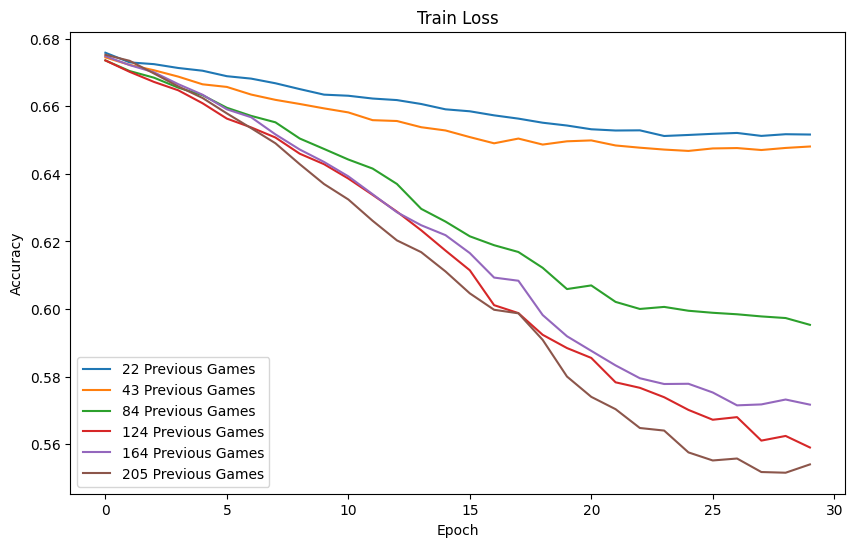

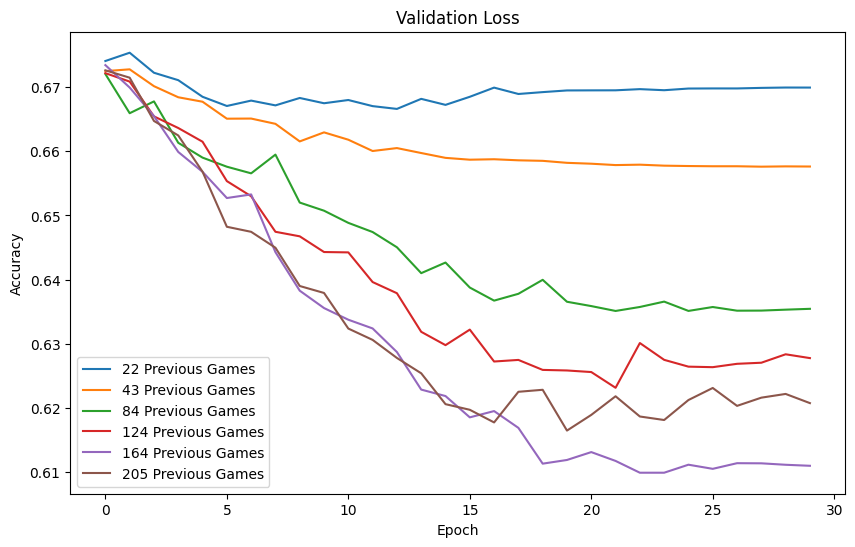

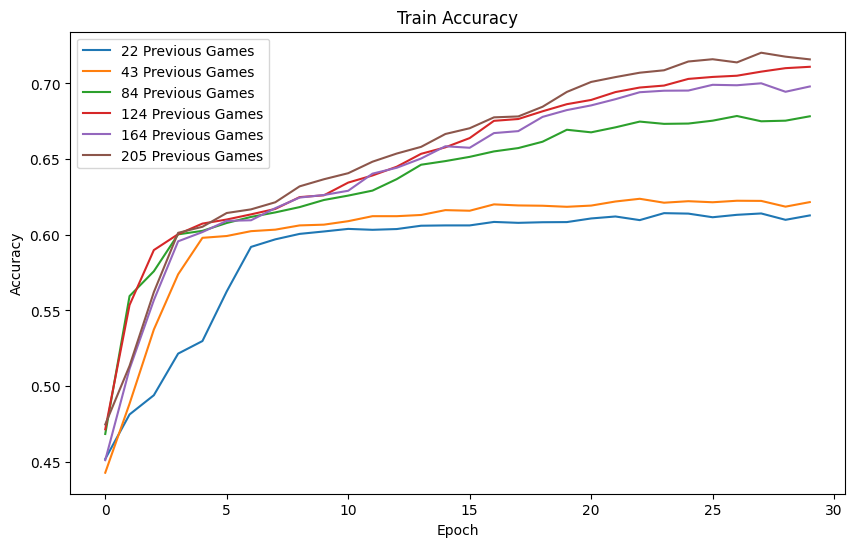

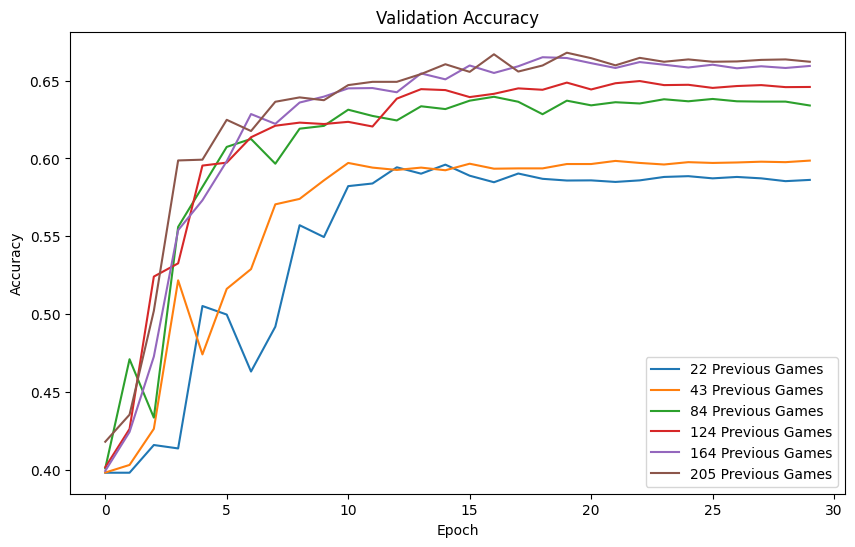

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

num_list = [10, 20, 40, 60, 80, 100]  # Example list of numbers

for line_num in range(4):  # Loop through lines 0, 1, 2, 3
    plt.figure(figsize=(10, 6))
    if line_num == 0:
      plt.title(f'Train Loss')
    elif line_num == 1:
      plt.title(f'Validation Loss')
    elif line_num == 2:
      plt.title(f'Train Accuracy')
    elif line_num == 3:
      plt.title(f'Validation Accuracy')

    for num in num_list:  # Loop through all files
        filename = f"{num}_new.txt"
        var_name = pd.read_csv(filename, header=None)
        var_name = var_name.map(lambda x: x.replace('[', '').replace(']', '') if isinstance(x, str) else x)
        array = var_name.values
        float_array = array.astype(np.float32)
        if num ==10: label = 22
        if num ==20: label = 43
        if num ==40: label = 84
        if num ==60: label = 124
        if num ==80: label = 164
        if num ==100: label = 205
        plt.plot(float_array[line_num, :30], label=f'{label} Previous Games')  # Plot the first 6 values of the specified line

    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.show()

### <img src="https://img.icons8.com/color/48/000000/code.png" style="height:50px;display:inline"> Model Illustration
---

In [ ]:
pip install visualkeras

In [ ]:

import visualkeras
import visualkeras
import torch
import torch.nn as nn
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, ReLU, MaxPooling2D, Dropout, Flatten, Dense

model = Sequential([
    Conv2D(16, kernel_size=3, input_shape=(128, 22, 53)),
    BatchNormalization(),
    ReLU(),
    Conv2D(32, kernel_size=3),
    BatchNormalization(),
    MaxPooling2D(pool_size=2, strides=2),
    Dropout(0.3),
    Conv2D(64, kernel_size=3),
    BatchNormalization(),
    ReLU(),
    Conv2D(128, kernel_size=3),
    BatchNormalization(),
    ReLU(),
    Conv2D(128, kernel_size=3),
    BatchNormalization(),
    Dropout(0.3),
    Conv2D(64, kernel_size=3),
    BatchNormalization(),
    ReLU(),
    Conv2D(48, kernel_size=3, padding='same'),
    BatchNormalization(),
    ReLU(),
    Conv2D(32, kernel_size=3, padding='same'),
    BatchNormalization(),
    ReLU(),
    Conv2D(16, kernel_size=3, padding='same'),
    BatchNormalization(),
    Dropout(0.3),
    ReLU(),
    Conv2D(8, kernel_size=3, padding='same'),
    ReLU(),
    MaxPooling2D(pool_size=2, strides=2),
    Flatten(),
    Dropout(0.3),
    Dense(530, activation='relu'),
    Dense(256, activation='relu'),
    Dense(48, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='linear')
])

visualkeras.layered_view(model,legend=True).show() # display using your system viewer
visualkeras.layered_view(model,legend=True, to_file='output.png') # write to disk
visualkeras.layered_view(model).show() # write and show

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")
/usr/local/lib/python3.10/dist-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


In [ ]:
# Used to save the results for future usage:

# from google.colab import files

# filename = f"{team_hist_size}.txt"

# with open(filename, 'w') as f:
#     for key, value in results.items():
#         f.write(f"{key}: {value}\n")

# files.download(filename)